In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Loading the libraries

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import math
from tensorflow import keras
from tensorflow.keras.layers import  Flatten , Input , Dense , Dropout, Concatenate , BatchNormalization , Conv2D , GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model ,load_model, save_model
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from sklearn.metrics import classification_report ,log_loss, accuracy_score , confusion_matrix, multilabel_confusion_matrix
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
%load_ext tensorboard
import datetime
from tensorflow.keras.utils import Sequence
import os

from PIL import Image
from pathlib import Path
from collections import defaultdict
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Lets define a custom metrics which we can use at the various stages of model experimentation

In [ ]:
# After some manual testing i found categorical_accuracy behaving hap-harzardly giving very different results in different experiments in multilel classification hence i went ahead and 
# implemented a custom metrics to calculate the same and we can see how the two metrics are not same

# https://stackoverflow.com/questions/53037451/keras-custom-metrics-for-multi-label-classfication


def full_multi_label_accuracy_score(y_true, y_pred):
    '''This function returns the full accuracy in multilabel problems.
    For example if y_true =[[1,1,1,1],
                            [1,0,1,0],
                            [0,0,0,0],
                            [0,0,0,1]]
                and y_pred =[[1,1,1,1],
                            [1,0,1,0],
                            [0,0,0,0],
                            [0,0,0,0]]

                The accuracy return will be 0.75 as it calculate full accuracy. As we can see the 4th entry doesnt match between y_true and y_pred
    '''
    comp = K.equal(y_true, K.round(y_pred))
    return K.mean(K.cast(K.all(comp, axis=-1), K.floatx()))


def dice_coef_differentiable(y_true, y_pred, smooth=K.epsilon()):
    y_true = K.cast(y_true,dtype='float32')
  # The original dice metric is not differentiable. This approxiation is used to make it differentiable
    intersection = K.sum(K.sum(y_true * y_pred,axis=1),axis=1)
    return K.mean((2. * intersection + smooth) / (K.sum(K.sum(y_true,axis=1),axis=1) + 
                                                       K.sum(K.sum(y_pred,axis=1),axis=1) + smooth))
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    intersection = K.sum(K.sum(y_true * K.round(y_pred),axis=1),axis=1)
    return K.mean((2. * intersection + smooth) / (K.sum(K.sum(y_true,axis=1),axis=1) + 
                                                       K.sum(K.sum(K.round(y_pred),axis=1),axis=1) + smooth))    

def dice_loss_differentiable(y_true, y_pred):
    return (1-dice_coef_differentiable(y_true,y_pred))


dependencies_segmentation = {
    'dice_coef_differentiable':dice_coef_differentiable,
    'dice_loss_differentiable' :dice_loss_differentiable,
    'dice_coef':dice_coef
}   

dependencies_multilable = {
    'full_multi_label_accuracy_score':full_multi_label_accuracy_score
} 

# Change the directory

In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Severstal

/content/drive/My Drive/Colab Notebooks/Severstal


# Load the models

In [ ]:
model_binary_restored = load_model('binary_model/tensorflow/bst_model45.ckpt')
model_multilabel_defect_only_restored = load_model('multilable_model_defect_only/bst_model50.ckpt',custom_objects=dependencies_multilable)
model_defect_1_segmentation_restored = load_model('segmentation_model_1/tensorflow/bst_model41.ckpt',custom_objects=dependencies_segmentation)
model_defect_2_segmentation_restored = load_model('segmentation_model_2/tensorflow/bst_model63.ckpt',custom_objects=dependencies_segmentation)
model_defect_3_segmentation_restored = load_model('segmentation_model_3/tensorflow/bst_model15.ckpt',custom_objects=dependencies_segmentation)
model_defect_4_segmentation_restored = load_model('segmentation_model_4/tensorflow/bst_model23.ckpt',custom_objects=dependencies_segmentation)

# Area of Defect

In [ ]:
def area(rle):
    '''
    Input: EncodedPixels (str)
    Output: number of pixels having the defect
    '''
    return sum([int(pixel) for pixel in rle.split(' ')[1::2]])
'''
Area threshold for various defect types
    Defect 1 - 400
    Defect 2 - 500
    Defect 3 - 800
    Defect 4 - 1900
'''   

'\nArea threshold for various defect types\n    Defect 1 - 400\n    Defect 2 - 500\n    Defect 3 - 800\n    Defect 4 - 1900\n'

# Reading Images 


In [ ]:
#https://cs230.stanford.edu/blog/datapipeline/
#https://www.tensorflow.org/guide/data

base_path ='test_images/'

#function to read the image and convert into pixel
def parse_function(image_path):
  image_string = tf.io.read_file(base_path+image_path)

  #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_jpeg(image_string, channels=3)

  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  # print(image)
  # print(label)

  return image


#function to augment the images
def augment(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta = 0.4)
  image = tf.image.random_crop(image, size=[224, 1568, 3])
  image = tf.clip_by_value(image, 0.0, 1.0)

  return image

#function to resize the images
def image_resize(image):
  resized_image = tf.image.resize(image, [256, 512])
  resized_image = tf.clip_by_value(resized_image, 0.0, 1.0)
  return resized_image

# Prediction Function

In [ ]:
# X can be a dataframe with an ImageId present
def pred_binary_multilable_classification_binary_segmentation(X):
    tta_steps = 5
    predictions_binary = []
    predictions_multilabel = []
    predictions_rles = []
    for i in tqdm(range(len(X))):
      img_name = X.iloc[i:i+1]['ImageId']
      #print(type(img_name))
      dataset = tf.data.Dataset.from_tensor_slices(img_name).repeat(tta_steps)
      augmented_test_batches = (
          dataset
          .map(parse_function, num_parallel_calls=AUTOTUNE)
          .map(augment, num_parallel_calls=AUTOTUNE)
          .map(image_resize)
          .batch(1)
          .prefetch(1)
      )
      y_pred_prob_binary = model_binary_restored.predict(augmented_test_batches).mean()
      predictions_binary.append(y_pred_prob_binary)
      if y_pred_prob_binary<0.55:
        predictions_rles.append(['','','',''])
        predictions_multilabel.append(['','','',''])
      else:
        y_pred_prob_multilabel = model_multilabel_defect_only_restored.predict(augmented_test_batches).mean(axis=0)
        predictions_multilabel.append(y_pred_prob_multilabel)
      
        rles = []
        img_name_seg = X.iloc[i:i+1]['ImageId'].values[0]
        x_i = np.expand_dims(image_resize(parse_function(img_name_seg)),axis=0)
        for j in range(4):
          if j == 0:
            model_name = model_defect_1_segmentation_restored
          elif j == 1:
            model_name = model_defect_2_segmentation_restored
          elif j == 2:
            model_name = model_defect_3_segmentation_restored
          elif j == 3:
            model_name = model_defect_4_segmentation_restored      

          if y_pred_prob_multilabel[j]>0.55:
            y_pred_prob_seg = model_name.predict(x_i)
            mask = (y_pred_prob_seg>0.5).astype('uint8')
            mask = cv2.resize(mask[0,:,:,:],(1600,256)) 
            rle = mask2rle(mask)
            area_defect=area(rle)
            if (j==0 and area_defect>400) or (j==1 and area_defect>500) or (j==2 and area_defect>800) or (j==3 and area_defect>1900):
              rles.append(rle)
            else: rles.append('')
          else: rles.append('') 
        predictions_rles.append(rles)  

    X_binary_multilable_classification_binary_segmentation = pd.DataFrame(X['ImageId'],columns = ['ImageId','has_defect','has_defect_1','has_defect_2','has_defect_3','has_defect_4','Defect_1','Defect_2','Defect_3','Defect_4'])
    X_binary_multilable_classification_binary_segmentation['has_defect'] = predictions_binary 
    X_binary_multilable_classification_binary_segmentation[['has_defect_1','has_defect_2','has_defect_3','has_defect_4']] = predictions_multilabel
    X_binary_multilable_classification_binary_segmentation[['Defect_1','Defect_2','Defect_3','Defect_4']]=predictions_rles

    return X_binary_multilable_classification_binary_segmentation 

# Function to convert mask to rle

In [ ]:
#https://www.kaggle.com/cdeotte/keras-unet-with-eda#%20https://www.kaggle.com/cdeotte/keras-unet-with-eda
def mask2rle(mask):
    mask_flatten = mask.flatten(order = 'F')
    # We will create another mask shifted by one digit and compare side by side
    masks_flatten_append0 = np.concatenate([[0], mask_flatten, [0]])
    runs = np.where(masks_flatten_append0[1:] != masks_flatten_append0[:-1])[0]+1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# for Training segmentation models we would need both the image pixels and the mask pixels and just output labels
# Hence we would need to have a custom generator which will take the image id and generate the image pixels
# and also oitput mask and then together that can be sent to the model. We will also need to create batches

def rle2mask(rle,shape=(256,1600)):
  mask_label = np.zeros(shape[0]*shape[1],dtype=np.float32)
  if not isinstance(rle, str):
    rle = rle.decode("utf-8")
  if rle is not np.nan and rle is not '':
    masks = rle.split(" ")
    positions = map(int, masks[0::2])
    lengths = map(int, masks[1::2])
    for pos, le in zip(positions,lengths):
      mask_label[pos-1:pos+le-1] = 1.
    # print(mask_label.reshape(shape[0], shape[1], order='F').shape)
  return np.expand_dims(mask_label.reshape(shape[0], shape[1], order='F'),-1)


##Function to display Image

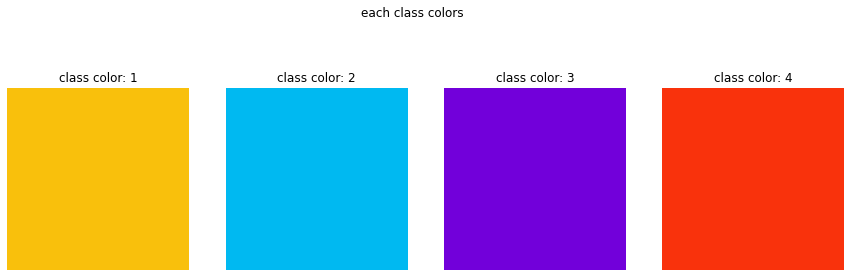

In [ ]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
# Lets define a pallete 
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [ ]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
# writing a function to create image mask for the defect area
def name_and_mask(img_name, rle_list):
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, rle in enumerate(rle_list):
        if rle is not '':
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            rle = rle.split(" ")
            positions = map(int, rle[0::2])
            length = map(int, rle[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_name, mask

In [ ]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
# function to show the image with the defect outline
def show_mask_image(img_name,rle_list):
    name, mask = name_and_mask(img_name, rle_list)
    img = cv2.imread(str(base_path+name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

# Function to convert the predictions into submission format

In [ ]:
def steel_prediction(X):
    tmp = []
    for i in range(len(X)):        
        ImageId,has_defect,has_defect_1,has_defect_2,has_defect_3,has_defect_4,Defect_1,Defect_2,Defect_3,Defect_4 = X.iloc[i]
        tmp.append([ImageId+'_1',Defect_1])
        tmp.append([ImageId+'_2',Defect_2])
        tmp.append([ImageId+'_3',Defect_3])
        tmp.append([ImageId+'_4',Defect_4])
    return pd.DataFrame(tmp, columns = ['ImageId_ClassId','EncodedPixels'])    

# Making predictions and generating the output on a batch dataset

In [ ]:
test_image_names = os.listdir(base_path)
test_dataframe = pd.DataFrame(test_image_names,columns=['ImageId'])
X_binary_multilable_classification_binary_segmentation_test  = pred_binary_multilable_classification_binary_segmentation(test_dataframe)
X= steel_prediction(X_binary_multilable_classification_binary_segmentation_test)
# X.to_csv('Predictions/13072020.csv',index=False)
X.shape

### Function to predict on a single data point

In [ ]:
# X can be a dataframe with an ImageId present
def pred_binary_multilable_classification_binary_segmentation(X):
    tta_steps = 5
    predictions_binary = []
    predictions_multilabel = []
    predictions_rles = []
    for i in range(1):
      img_name = pd.Series([X])
      dataset = tf.data.Dataset.from_tensor_slices(img_name).repeat(tta_steps)
      augmented_test_batches = (
          dataset
          .map(parse_function, num_parallel_calls=AUTOTUNE)
          .map(augment, num_parallel_calls=AUTOTUNE)
          .map(image_resize)
          .batch(1)
          .prefetch(1)
      )
      y_pred_prob_binary = model_binary_restored.predict(augmented_test_batches).mean()
      predictions_binary.append(y_pred_prob_binary)
      if y_pred_prob_binary<0.55:
        predictions_rles.append(['','','',''])
        predictions_multilabel.append(['','','',''])
        print("Non-Defective")
      else:
        y_pred_prob_multilabel = model_multilabel_defect_only_restored.predict(augmented_test_batches).mean(axis=0)
        predictions_multilabel.append(y_pred_prob_multilabel)
      
        rles = []
        img_name_seg = X
        x_i = np.expand_dims(image_resize(parse_function(img_name_seg)),axis=0)
        for j in range(4):
          if j == 0:
            model_name = model_defect_1_segmentation_restored
          elif j == 1:
            model_name = model_defect_2_segmentation_restored
          elif j == 2:
            model_name = model_defect_3_segmentation_restored
          elif j == 3:
            model_name = model_defect_4_segmentation_restored      

          if y_pred_prob_multilabel[j]>0.55:
            y_pred_prob_seg = model_name.predict(x_i)
            mask = (y_pred_prob_seg>0.5).astype('uint8')
            mask = cv2.resize(mask[0,:,:,:],(1600,256)) 
            rle = mask2rle(mask)
            area_defect=area(rle)
            if (j==0 and area_defect>400) or (j==1 and area_defect>500) or (j==2 and area_defect>800) or (j==3 and area_defect>1900):
              rles.append(rle)
            else: rles.append('')
          else: rles.append('') 
        predictions_rles.append(rles)  
        #print(X)
        #print(predictions_rles[0])
        show_mask_image(X,predictions_rles[0])

In [ ]:
pred_binary_multilable_classification_binary_segmentation('00a0b7730.jpg')

Non-Defective


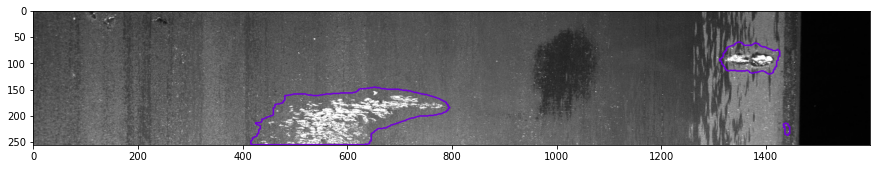

In [ ]:
pred_binary_multilable_classification_binary_segmentation('0042e163f.jpg')

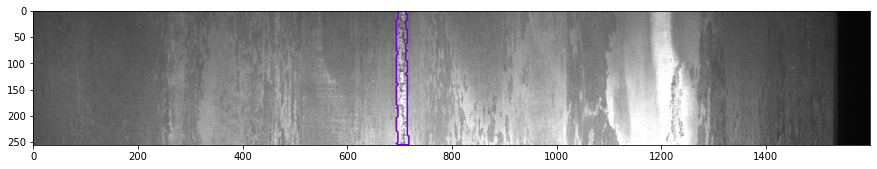

In [ ]:
pred_binary_multilable_classification_binary_segmentation('00d72c660.jpg')

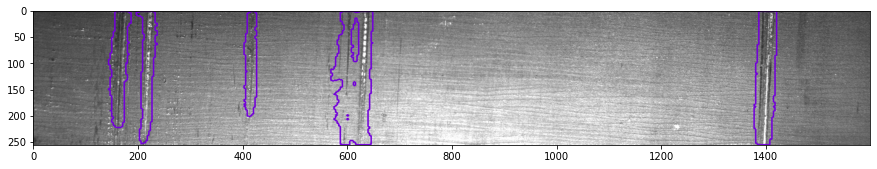

In [ ]:
pred_binary_multilable_classification_binary_segmentation('010ec96b4.jpg')

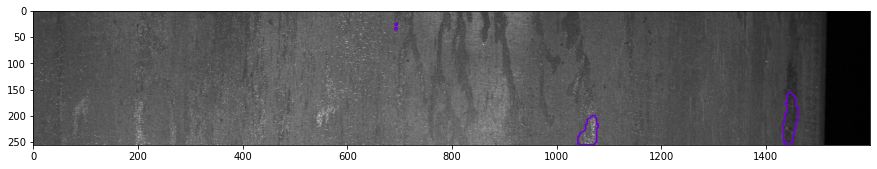

In [ ]:
pred_binary_multilable_classification_binary_segmentation('006f39c41.jpg')

In [ ]:
pred_binary_multilable_classification_binary_segmentation('0098ca44e.jpg')

Non-Defective
